In [16]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

In [33]:
from pyldl.utils import encode_one_hot, kullback_leibler_divergence
from pyldl.layers import AutoEncoder, Sequential
from pyldl.modules import Linear
from pyldl.losses import BCELoss, MSELoss
from pyldl.activations import Sigmoid, Tanh, Softmax
from pyldl.optimizers import Optim, SGD

from sklearn.datasets import load_digits, fetch_olivetti_faces
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np

# Loading the digits data set

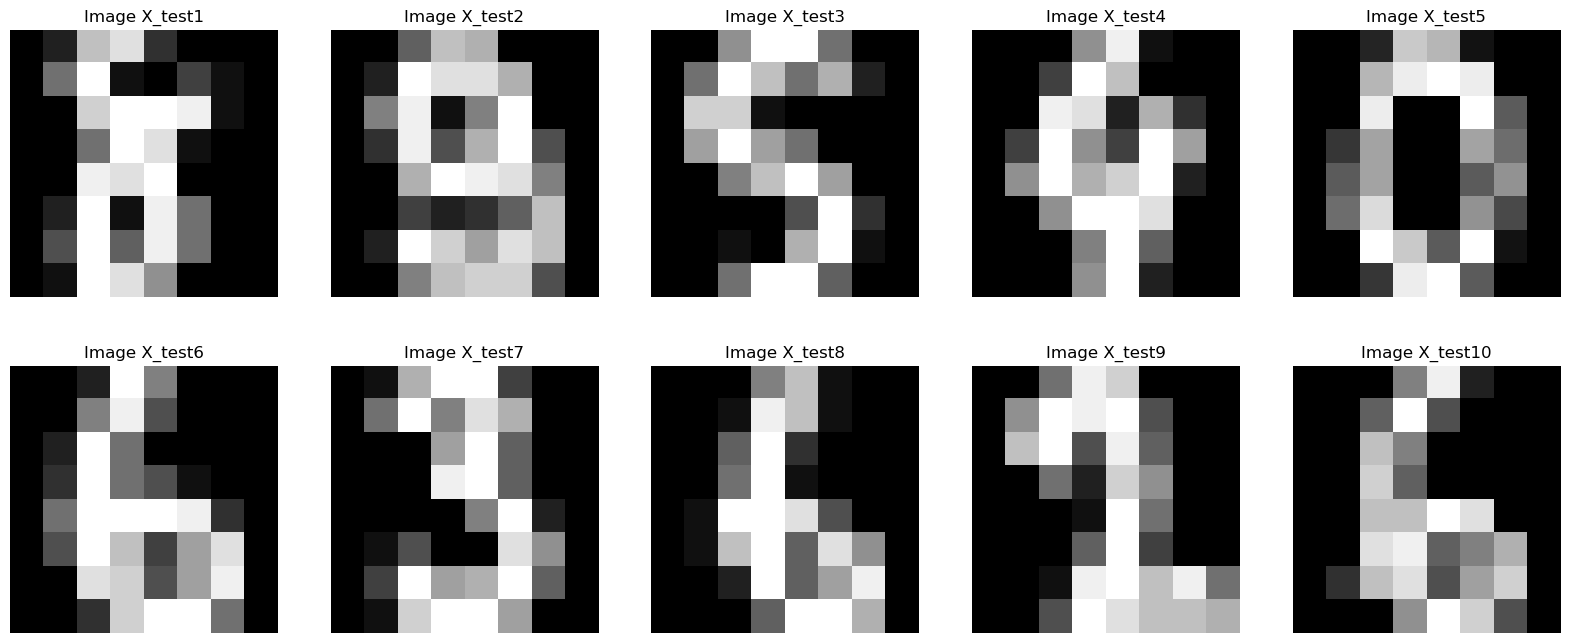

In [18]:
digits = load_digits()

X = digits.data

X_train, X_test = train_test_split(X, test_size=0.2)

n_images = 10

random_indexes = np.random.choice(range(len(X_test)), n_images)
images = X_test[random_indexes]


plt.figure(figsize=(20, 8))
for i in range(n_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Image X_test{i+1}")
    plt.axis('off')
plt.show()


In [19]:
def add_noise(data, sigma=0.05):
    return data + sigma * np.random.randn(*data.shape) 

In [20]:
from itertools import product

def grid_search(X_train, X_test, params):
    best_score = np.inf
    best_model = None
    best_params = None
    best_losses = None
    for activation, batch_size, gradient_step, loss, n_epochs, n_neurons_per_layer in product(*params.values()):
        encoder_layers, decoder_layers = [], []
        for i in range(len(n_neurons_per_layer)-1):
            encoder_layers += [Linear(n_neurons_per_layer[i], n_neurons_per_layer[i+1]), activation()]
            decoder_layers = [Linear(n_neurons_per_layer[i+1], n_neurons_per_layer[i]), activation()] + decoder_layers
        autoencoder = AutoEncoder(Sequential(*encoder_layers), Sequential(*decoder_layers))
        losses = SGD(autoencoder, loss(), X_train, X_train, batch_size=batch_size, gradient_step=gradient_step, n_iter=n_epochs)
        reconstructed_images = autoencoder(X_test)
        score = np.abs(kullback_leibler_divergence(X_test, reconstructed_images))
        if score < best_score:
            best_model = autoencoder
            best_score = score
            best_losses = losses
            best_params = {
                "activation_functions": activation.__class__.__name__,
                "batch_size": batch_size,
                "gradient_step": gradient_step,
                "loss": loss.__class__.__name__,
                "n_epochs": n_epochs,
                "n_neurons_per_layer": n_neurons_per_layer,
            }
    return best_model, best_params, best_score, best_losses

In [30]:
# params = {
#     "activation_functions": [Sigmoid, Tanh],
#     "batch_size": [32, 64, 128],
#     "gradient_step": [0.01, 0.001, 0.0001],
#     "loss": [BCELoss, MSELoss],
#     "n_epochs": [500, 1000, 2000],
#     "n_neurons_per_layer": [[X_noise.shape[1], 64], [X_noise.shape[1], 64, 32], [X_noise.shape[1], 64, 32, 16]],
# }


params = {
    "activation_functions": [Tanh],
    "batch_size": [32],
    "gradient_step": [0.001],
    "loss": [MSELoss],
    "n_epochs": [1000],
    "n_neurons_per_layer": [[X_train.shape[1], 32, 16, 2]],
}

X_noised = add_noise(X_train, sigma=0.6)
# Min-Max Scaling
x_min = X_noised.min()
x_max = X_noised.max()
X_noise = (X_noised - x_min) / (x_max - x_min)


best_model, best_params, best_score, best_losses = grid_search(X_noise, X_test, params)

print(f"Best model: {best_model}")
print(f"Best params: {best_params}")
print(f"Best score: {best_score}")
print(f"Best losses: {best_losses}")

100%|██████████| 1000/1000 [00:23<00:00, 41.87it/s]

Best model: <pyldl.layers.AutoEncoder object at 0x76105e3e5450>
Best params: {'activation_functions': 'ABCMeta', 'batch_size': 32, 'gradient_step': 0.001, 'loss': 'ABCMeta', 'n_epochs': 1000, 'n_neurons_per_layer': [64, 32, 16, 2]}
Best score: 930.0156715848183
Best losses: [3.652091441274367, 2.8962802628888205, 2.8921624459229758, 2.885895808419747, 2.8718733811207446, 2.825727747883417, 2.6792132223037988, 2.5426308144019627, 2.4999813076493744, 2.467724607464651, 2.4037718930134173, 2.2863121151405372, 2.1795452572158225, 2.131654873141325, 2.1140758530728827, 2.105256117312407, 2.099410368143062, 2.094968015444684, 2.09133392413248, 2.0882221021442646, 2.0854742900599295, 2.0829929833154144, 2.0807120291470405, 2.0785824506196158, 2.076565206416984, 2.074627320447626, 2.072739703573219, 2.0708758393256654, 2.0690109158409955, 2.067121190812482, 2.065183479687441, 2.0631747107426484, 2.0610715195678657, 2.0588498728280435, 2.0564847246516678, 2.0539497245001876, 2.05121701742106, 2

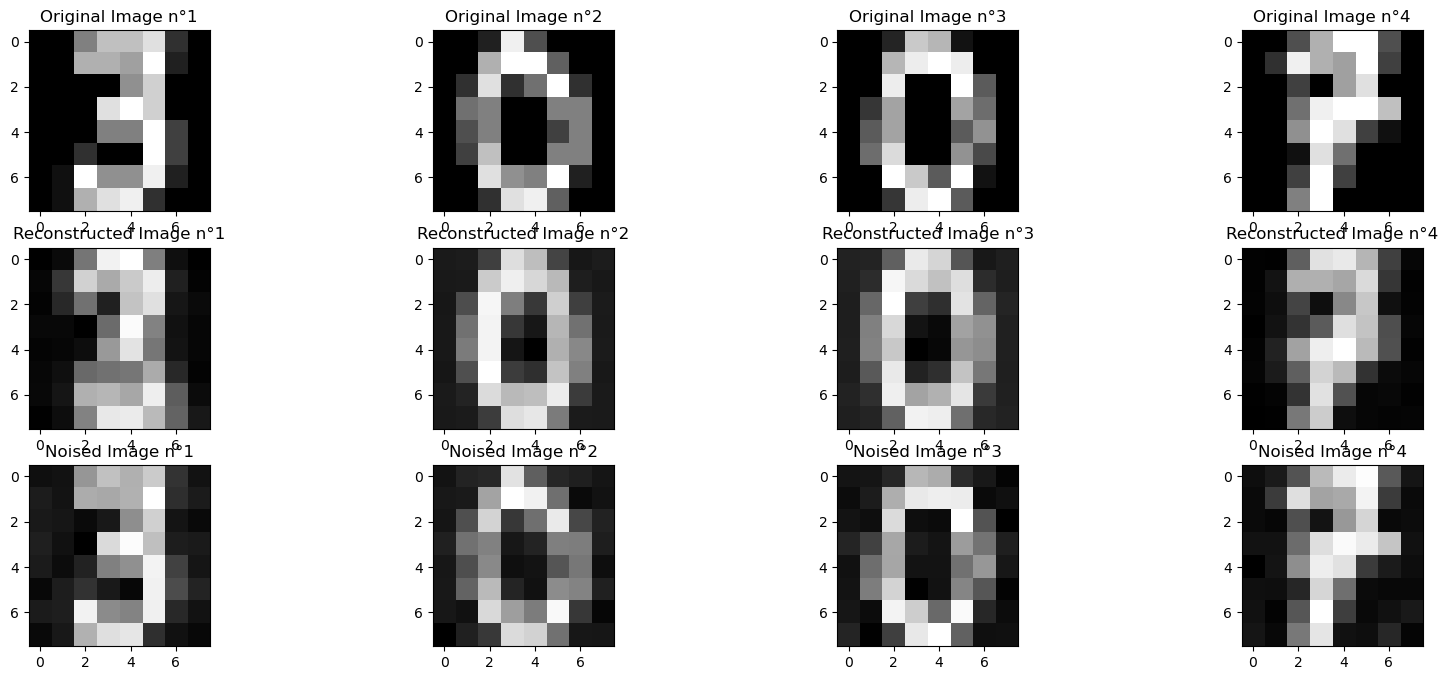

In [31]:
n_images = 8
subplots_size = n_images//2

random_indexes = np.random.choice(range(X_test.shape[0]), subplots_size, replace=False)
original_images = X_test[random_indexes]
reconstructed_images = best_model(original_images)
noised_images = add_noise(original_images, sigma=0.6)

plt.subplots(3, 4, figsize=(20, 8))
for i in range(subplots_size):
    plt.subplot(3, 4, i+1)
    plt.title(f"Original Image n°{i+1}")
    plt.imshow(original_images[i].reshape(8,8), cmap='gray')
    plt.subplot(3, 4, subplots_size+i+1)
    plt.title(f"Reconstructed Image n°{i+1}")
    plt.imshow(reconstructed_images[i].reshape(8,8), cmap='gray')
    plt.subplot(3, 4, 2*subplots_size+i+1)
    plt.title(f"Noised Image n°{i+1}")
    plt.imshow(noised_images[i].reshape(8,8), cmap='gray')


# Loading the olivetti faces data set

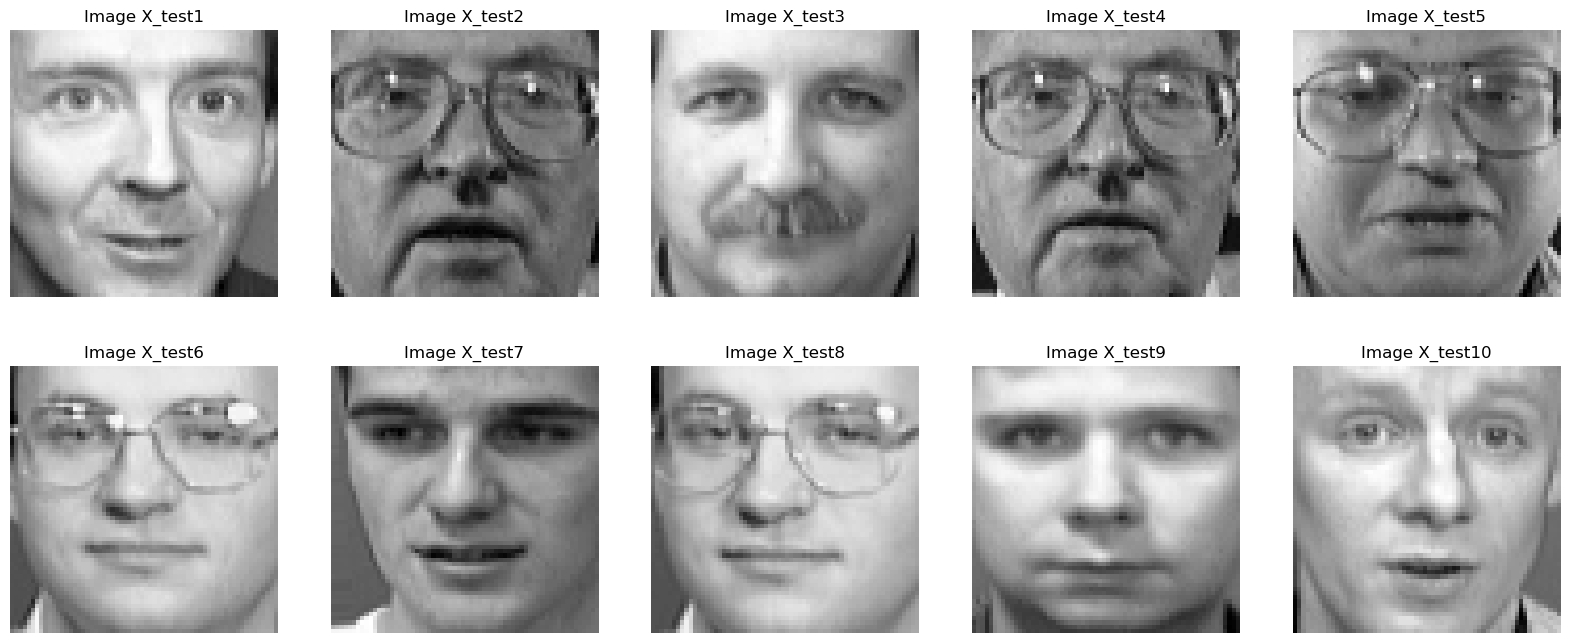

In [42]:
faces = fetch_olivetti_faces()

X = faces.data

X_train, X_test = train_test_split(X, test_size=0.2)

n_images = 10

random_indexes = np.random.choice(range(len(X_test)), n_images)
images = X_test[random_indexes]


plt.figure(figsize=(20, 8))
for i in range(n_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(64, 64), cmap='gray')
    plt.title(f"Image X_test{i+1}")
    plt.axis('off')
plt.show()


In [43]:
params = {
    "activation_functions": [Tanh],
    "batch_size": [32],
    "gradient_step": [0.001],
    "loss": [MSELoss],
    "n_epochs": [1000],
    "n_neurons_per_layer": [[X_train.shape[1], 32, 16, 2]],
}

X_noised = add_noise(X_train, sigma=0.05)
# Min-Max Scaling
x_min = X_noised.min()
x_max = X_noised.max()
X_noise = (X_noised - x_min) / (x_max - x_min)


best_model, best_params, best_score, best_losses = grid_search(X_noise, X_test, params)

print(f"Best model: {best_model}")
print(f"Best params: {best_params}")
print(f"Best score: {best_score}")
print(f"Best losses: {best_losses}")

100%|██████████| 1000/1000 [00:59<00:00, 16.79it/s]

Best model: <pyldl.layers.AutoEncoder object at 0x76105e7c8ad0>
Best params: {'activation_functions': 'ABCMeta', 'batch_size': 32, 'gradient_step': 0.001, 'loss': 'ABCMeta', 'n_epochs': 1000, 'n_neurons_per_layer': [4096, 32, 16, 2]}
Best score: 29.833597370137994
Best losses: [544.6166165887932, 59.728755855942026, 59.22494216549383, 59.22473720320416, 59.224617932619786, 59.22449295030507, 59.224362623859385, 59.2242266491456, 59.22408466524869, 59.223936281435286, 59.22378107602691, 59.223618593954406, 59.22344834413671, 59.223269796756384, 59.22308238047147, 59.22288547962048, 59.2226784314999, 59.22246052382386, 59.22223099251492, 59.221989020023464, 59.22173373443469, 59.221464209698766, 59.221179467411204, 59.22087848068244, 59.22056018076538, 59.220223467259906, 59.2198672228795, 59.2194903339457, 59.219091717957795, 59.21867035975797, 59.218225357951475, 59.21775598331558, 59.21726175089229, 59.216742507230286, 59.2161985337053, 59.215630665815794, 59.21504042653605, 59.214430

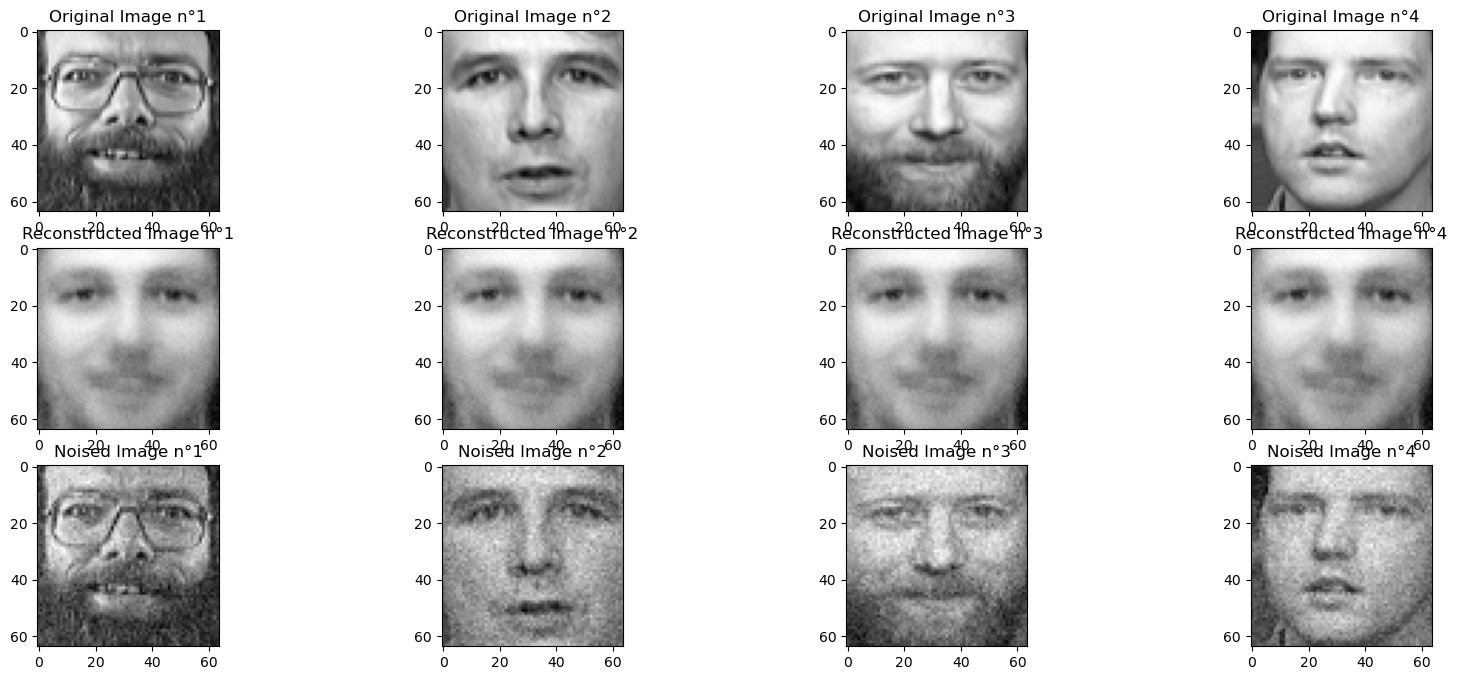

In [45]:
n_images = 8
subplots_size = n_images//2

random_indexes = np.random.choice(range(X_test.shape[0]), subplots_size, replace=False)
original_images = X_test[random_indexes]
reconstructed_images = best_model(original_images)
noised_images = add_noise(original_images, sigma=0.05)

plt.subplots(3, 4, figsize=(20, 8))
for i in range(subplots_size):
    plt.subplot(3, 4, i+1)
    plt.title(f"Original Image n°{i+1}")
    plt.imshow(original_images[i].reshape(64,64), cmap='gray')
    plt.subplot(3, 4, subplots_size+i+1)
    plt.title(f"Reconstructed Image n°{i+1}")
    plt.imshow(reconstructed_images[i].reshape(64,64), cmap='gray')
    plt.subplot(3, 4, 2*subplots_size+i+1)
    plt.title(f"Noised Image n°{i+1}")
    plt.imshow(noised_images[i].reshape(64,64), cmap='gray')
